# Headphone dataset review analysis #

Analyze how customers expressed their feelings about headphones bought through Amazon

Full conclusions from explanatory data analysis are provided at the bottom of the notebook. 

Data from: https://www.kaggle.com/datasets/mdwaquarazam/headphone-dataset-review-analysis

---

### ***Imports*** ###

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from wordcloud import WordCloud, ImageColorGenerator

from spacy.lang.en.stop_words import STOP_WORDS
import string
from PIL import Image
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize

In [2]:
# Set of colors to use in plots
plt.style.use('ggplot')
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
%matplotlib inline

---

### ***General data profiling*** ###

In [4]:
df = pd.read_csv('inputs/headphone_datn.csv')

In [5]:
df.head(5) # preview data

,Customer_Name,REVIEW_TITLE,Color,REVIEW_DATE,COMMENTS,RATINGS
0,Ramdika,Really Exceed my expectation.,Black,30-May-21,Okay.. I was skeptical at first to buy this as...,5
1,Sachin AK,Great for a change from inear buds,Black,01-Jun-21,The earphone is worth what you pay for. The de...,5
2,Manikandan Raj,For people with sensitive ears,Black,05-Sep-21,"Particularly for people with sensitive ears, w...",4
3,Reviewguy,I tested it for a week and here's a detailed r...,Iguana,11-Sep-21,Built Quality 6.5 10The lower wire is a durabl...,4
4,Sridhar Sarkar,Not a good headphone,Iguana,26-Jun-21,Don't go with the over all 4 start rating. Thi...,2


In [6]:
df.shape # how many observations and features are there

(1604, 6)

In [7]:
df.isna().sum() # how many empty string are there

Customer_Name     0
REVIEW_TITLE     10
Color             0
REVIEW_DATE       0
COMMENTS         58
RATINGS           0
dtype: int64

In [8]:
# show observations with an empty comment and an empty review title
df[df['COMMENTS'].isna() & df['REVIEW_TITLE'].isna()] 

,Customer_Name,REVIEW_TITLE,Color,REVIEW_DATE,COMMENTS,RATINGS
807,janak baldaniya,NaN,Spirit Lime,03-Jan-22,NaN,4
1535,SANTHOSH,NaN,Blue,04-Oct-21,NaN,4


In [9]:
df[df['COMMENTS'].isna()] # display empty reviews

,Customer_Name,REVIEW_TITLE,Color,REVIEW_DATE,COMMENTS,RATINGS
345,g.pradeep kumar,Simple and stylish,Black,13-Jun-21,NaN,5
531,chandana,Mic not working after month,White,01-Jan-22,NaN,1
635,Pooja Rane,Good Sound Quality,White,10-Jan-22,NaN,5
716,Amazon Customer,Good,Spirit Lime,09-Dec-21,NaN,5
746,Abhra Kanti Mukherjee,Comfortable and efficient,Iguana,09-Jan-22,NaN,5
807,janak baldaniya,NaN,Spirit Lime,03-Jan-22,NaN,4
828,Unnati,Loved these earphones.,Iguana,08-Nov-21,NaN,5
882,rajesh kumar,Voice cals not working,Blue,17-Nov-21,NaN,1
903,Rony J Gharami,Money valued product at low cost.,Spirit Lime,08-Nov-21,NaN,4
983,Sai Sharvani,Awesome Sound Quality worth buying it .,White,05-May-22,NaN,5


In [10]:
df['Color'].value_counts(normalize=True) # show distribution of colors in reviews

White          0.283042
Black          0.279925
Spirit Lime    0.147132
Blue           0.145885
Iguana         0.144015
Name: Color, dtype: float64

---

### ***Main classes and functions*** ###

In [11]:
class tiny_preprocessing(object):
    '''
    Simple preprocessing class for text cleanup. Only basic functions are included.
    '''
    def __init__(self, text):
        self.text = text
    
    def __getitem__(self, index):
        return self.text[index]
    
    def lower(self):
        self.text = self.text.map(lambda x: str(x).lower())
        return self.text

    def remove_stop_words(self):
        self.text = self.text.map(lambda x: ' '.join([elem for elem in x.split() if elem not in STOP_WORDS]))
        return self.text
    
    def remove_punctuation(self):
        self.text = self.text.map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))
        return self.text

    def simple_preprocess(self):
        self.lower()
        self.remove_stop_words()
        self.remove_punctuation()


In [12]:
def visualize_dict(words_freq: dict, plot_title: str, color_number = 1):
    '''
    Display a horizontal bar plot from a dictionary

    Args:
        words_freq: dictionary with words as keys and frequencies as values
        plot_title: title of plot
        color_numer: number from 0 to 6 represnting color
    
    Returns:
        Plot of word frequencies displayed as a horizontal bar plot
    '''
    plt.title(plot_title)
    plt.barh(*zip(*sorted(words_freq.items(), key = lambda x: x[1])), color = cycle_colors[color_number]);

In [13]:
def hist_plot(col_name: str, plot_title: str, percentile = None):
    '''
    Display a distribution plot of a specific column of a dataset. If a percentile
    is privided - display a distrubution plot of a specific data up to a certain
    percentile

    Args:
        col_name: name of column in dataset
        plot_title: title of plot
        percentile (optional): percentile of a feature
    '''
    plt.title(plot_title)
    if percentile == None:
        sns.histplot(data = df[col_name]);
    else:
        sns.histplot(df[df[col_name] < np.percentile(df[col_name], percentile)][col_name]);

---

### ***Text preprocessing*** ###

Comments preprocessing

In [14]:
data = tiny_preprocessing(df['COMMENTS'])
data.simple_preprocess()

data[:]

0       okay skeptical buy tight budget  honest little...
1       earphone worth pay for design earbud cause pai...
2       particularly people sensitive ears gets ear pa...
3       built quality 65 10the lower wire durable nylo...
4       dont 4 start rating boat brand endorse lot mon...
                              ...                        
1599         good sound qualityand impressively good bass
1600                                                  osm
1601    earphones fits ears doesnt block ear outside s...
1602              sound quality bad bad product happy buy
1603             callsmic goodbut comfort bad music worst
Name: COMMENTS, Length: 1604, dtype: object

Review titles preprocessing

In [15]:
data_rev = tiny_preprocessing(df['REVIEW_TITLE'])
data_rev.simple_preprocess()

data_rev[:]

0                      exceed expectation
1                 great change inear buds
2                   people sensitive ears
3       tested week heres detailed review
4                          good headphone
                      ...                
1599                          simply fine
1600                          value money
1601                          value money
1602     duplicate headphones worth price
1603                      worstonly calls
Name: REVIEW_TITLE, Length: 1604, dtype: object

Add preprocessed data to dataframe

In [16]:
df['comments_prep'] = data[:]
df['review_prep'] = data_rev[:]

Build main corpus

In [17]:
def build_corpus(preprocessed_comments: pd.Series) -> list:
    '''
    Build a corpus - a list of all tokens (with repetitions)

    Args:
        preprocessed_comments: dataframe column with preprocessed comments 
        (as string)
    Returns:
        A list of all preprocessed tokens used in the dataset
    '''
    # split commments into tokens
    comments_prep_tokens = preprocessed_comments.str.split() 
    corpus = [] # make empty corpus
    for token in comments_prep_tokens:
        corpus += token # add token to corpus
    return corpus

corpus = build_corpus(df['comments_prep'])

---

### ***Word cloud logo generation*** ###

In [18]:
# change image to numpy array
mask = np.array(Image.open('inputs/headphone-8215.jpg'))

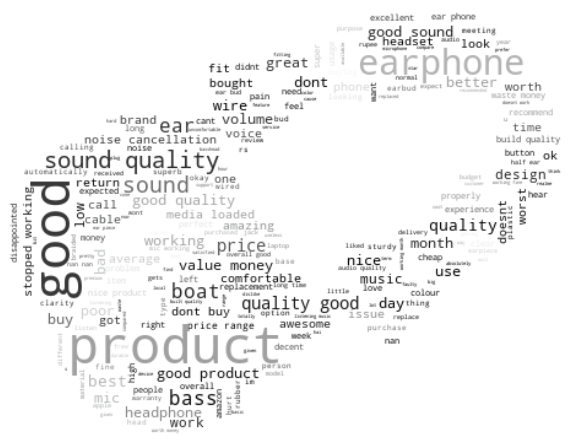

In [19]:
# wordcloud generation
wc = WordCloud(background_color='white', max_words=500, mask = mask, max_font_size=60, random_state=0)
text = ' '.join(data[:]) # join all reviews into one single text
wc.generate(text)

image_colors = ImageColorGenerator(mask)
image_colors.default_color = [0,0,0]

plt.figure(figsize=[10,10])
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off");
plt.savefig('outputs/headphone_word_cloud.png')

---

### ***Basic statistics for comments*** ###

Statistics done on raw text

Character count

In [20]:
df['char_counts'] = df['COMMENTS'].map(lambda x: len(str(x)))

Word count

In [21]:
df['word_counts'] = df['COMMENTS'].map(lambda x: len(str(x).split()))

Sentence count

In [22]:
df['sent_counts'] = df['COMMENTS'].map(lambda x: len(sent_tokenize(str(x))))

Average word length

In [23]:
df['avg_word_len'] = df["COMMENTS"].map(lambda x: np.mean([len(w) for w in str(x).split()]))

Average sentence length

In [24]:
df['avg_sent_len'] = df['COMMENTS'].map(lambda x: np.mean([len(s.split()) for s in sent_tokenize(str(x))]))

---

### ***Basic statistics for review titles*** ###

Statistics done on raw text

Character count

In [25]:
df['char_counts_rev'] = df['REVIEW_TITLE'].map(lambda x: len(str(x)))

Word count

In [26]:
df['word_counts_rev'] = df['REVIEW_TITLE'].map(lambda x: len(str(x).split()))

Sentence count

In [27]:
df['sent_counts_rev'] = df['REVIEW_TITLE'].map(lambda x: len(sent_tokenize(str(x))))

Average word length

In [28]:
df['avg_word_len_rev'] = df['REVIEW_TITLE'].map(lambda x: np.mean([len(w) for w in str(x).split()]))

Average sent length

In [29]:
df['avg_sent_len_rev'] = df['REVIEW_TITLE'].map(lambda x: np.mean([len(s.split()) for s in sent_tokenize(str(x))]))

---

### ***Basic statistics for customers*** ###

Is the customer anonymous

In [30]:
df['Customer_Name'].value_counts()

Amazon Customer       86
Rahul                  5
Abhishek               4
Akash                  3
Yogesh                 3
                      ..
DHARMENDRA SINGH       1
Madhava Vanapilli      1
RAMSIYA SAKET          1
SANJAY KUMAR MURMU     1
Anjali Singh           1
Name: Customer_Name, Length: 1465, dtype: int64

How many individual customers are there

In [31]:
df['Customer_Name'].nunique()

1465

Check if a customer left their name

In [32]:
df['anonymous_customer'] = df['Customer_Name'].map(lambda x: True if x != 'Amazon Customer' else False)

---

### ***Distribution plots*** ###

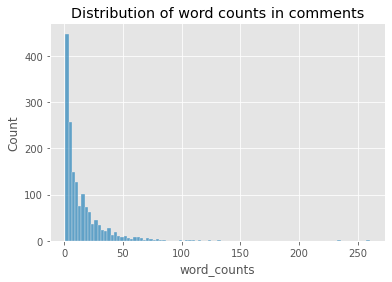

In [33]:
hist_plot('word_counts', 'Distribution of word counts in comments')

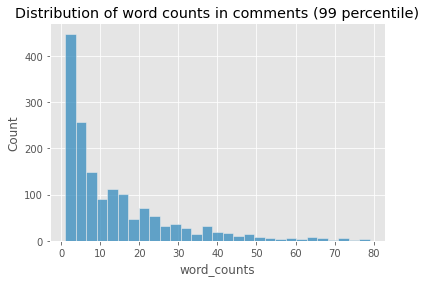

In [34]:
hist_plot('word_counts', 'Distribution of word counts in comments (99 percentile)', 99)

In [35]:
np.median(df['word_counts']) # median number of words in comments

8.0

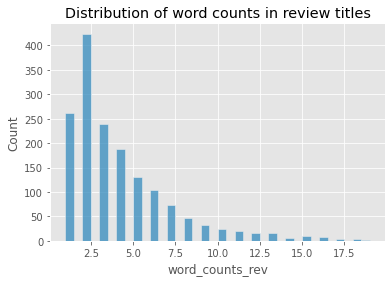

In [36]:
hist_plot('word_counts_rev', 'Distribution of word counts in review titles')

In [37]:
np.median(df['word_counts_rev']) # median number of words in the title

3.0

In [38]:
df['word_counts_rev'].max() # maximal number of words in a title

19

c:\Users\mariu\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


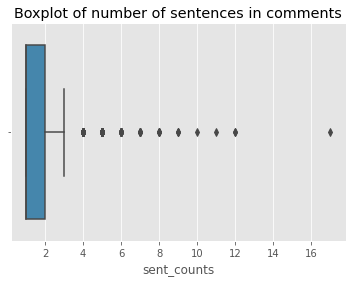

In [39]:
plt.title('Boxplot of number of sentences in comments')
sns.boxplot(df['sent_counts'], color= cycle_colors[1]);

In [40]:
df['sent_counts'].describe()

count    1604.000000
mean        1.593516
std         1.336883
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        17.000000
Name: sent_counts, dtype: float64

---

### ***General Term Frequency Analysis*** ###

Show most common words

In [41]:
most_common_words = nltk.FreqDist(corpus).most_common(10)
most_common_words

[('good', 673),
 ('quality', 543),
 ('sound', 467),
 ('product', 414),
 ('bass', 166),
 ('ear', 151),
 ('working', 151),
 ('boat', 149),
 ('price', 145),
 ('earphones', 140)]

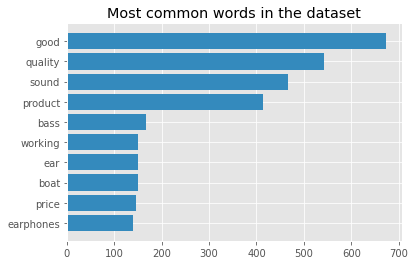

In [42]:
visualize_dict(dict(most_common_words), 'Most common words in the dataset', 1)

In [43]:
print(f'Word count of the word "very": {nltk.FreqDist(corpus)["very"]}')
print(f'Word count of the word "not": {nltk.FreqDist(corpus)["not"]}') # check for possible negations

Word count of the word "very": 1
Word count of the word "not": 2


---

### ***Sentiment based term frequency analysis*** ###

Sentiment construction based an ratings

In [44]:
sentiment_dict = {'positive': [5, 4], 'neutral': [3], 'negative': [1, 2]}

In [45]:
def key_return(x: int) -> str:
    '''
    Change ratings to sentiments. This function should be used with the help 
    of map function on a dataframe column.
    Looks through the lists, that are the values of the dictionary. If x in 
    present in any of those lists, it's key is returned.

    Args:
        x: number from 1 do 5
    
    Returns:
        Dictionary key if a number exists in a list, that if associated with 
        that key
    '''
    return next(k for k,v in sentiment_dict.items() if x in v)

df['RATINGS_SENTIMENT'] = df['RATINGS'].map(lambda x: key_return(x))

In [46]:
# how many positve, neutral and negative comments are there
df['RATINGS_SENTIMENT'].value_counts(normalize = True)

positive    0.581671
negative    0.324190
neutral     0.094140
Name: RATINGS_SENTIMENT, dtype: float64

Positive comments

In [47]:
def build_corpus_pos_neg(sentiment_type: str) -> list:
    '''
    Build a positive or negative corpus of tokens.

    Args:
        sentument_type ('positive' or 'negative'): type of sentiment to use

    Returns:
        A list of preprocessed tokens used in the dataset
    '''
    tokens = df[df['RATINGS_SENTIMENT'] == sentiment_type]['comments_prep'].str.split()
    corpus = [] # make empty corpus
    for token in tokens:
        corpus += token # add token to corpus
    return corpus

In [48]:
positive_corpus = build_corpus_pos_neg('positive')

In [49]:
most_common_words_positive = nltk.FreqDist(positive_corpus).most_common(10)

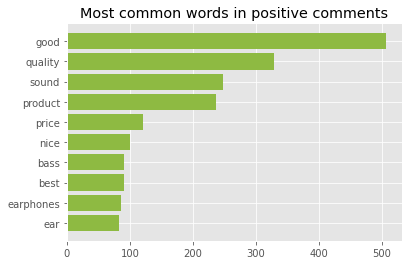

In [50]:
visualize_dict(dict(most_common_words_positive), 'Most common words in positive comments', 5)

Negative comments

In [51]:
negative_corpus = build_corpus_pos_neg('negative')

In [52]:
most_common_words_negative = nltk.FreqDist(negative_corpus).most_common(10)

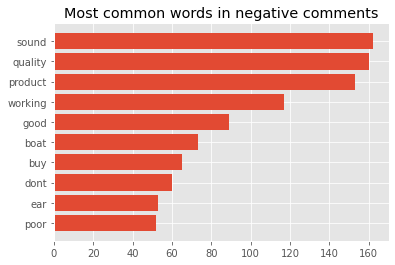

In [53]:
visualize_dict(dict(most_common_words_negative), 'Most common words in negative comments', 0)

---

### ***N-grams Frequency Analysis*** ###

All tokens

In [54]:
vec = CountVectorizer(ngram_range=(2,2))
bow = vec.fit_transform(df['comments_prep'])

In [55]:
count_values = bow.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in vec.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

In [56]:
ngram_freq

,frequency,ngram
0,217,sound quality
1,103,quality good
2,75,good product
3,68,value money
4,66,good quality
...,...,...
8261,1,10 couple
8262,1,10 built
8263,1,10 better
8264,1,10 audio


In [77]:
def make_bi_grams_dict(corpus: list) -> dict:
    '''
    Make a dictionary of bi-grams frequencies

    Args:
        corpus: text corpus (list of tokens)
    
    Returns:
        Dictionary with bigrams as keys and word counts (frequencies)
        as values
    '''

    n_grams = nltk.FreqDist(list(nltk.ngrams(corpus, 2))) # n_grams as list of tuples
    most_common_n_grams = n_grams.most_common(10)

    return {' '.join(k): v for k, v in dict(most_common_n_grams).items()}

In [80]:
bi_grams_dict = make_bi_grams_dict(corpus)

In [81]:
bi_grams_dict

{'sound quality': 218,
 'quality good': 109,
 'good product': 77,
 'value money': 68,
 'good quality': 68,
 'good sound': 66,
 'product good': 44,
 'noise cancellation': 44,
 'stopped working': 39,
 'dont buy': 39}

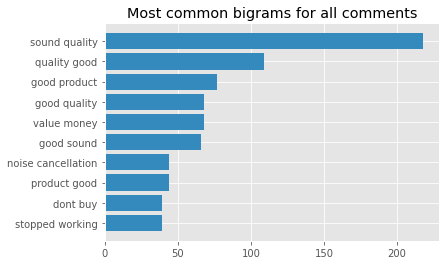

In [82]:
visualize_dict(bi_grams_dict, 'Most common bigrams for all comments', 1)

Only positive reviews

In [83]:
positive_bi_grams_dict = make_bi_grams_dict(positive_corpus)

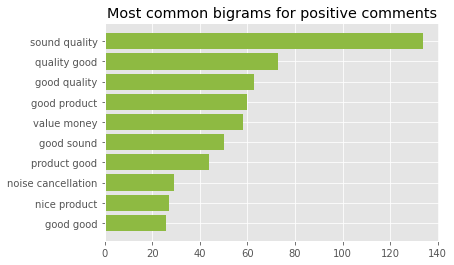

In [84]:
visualize_dict(positive_bi_grams_dict, 'Most common bigrams for positive comments', 5)

Only negative comments

In [85]:
negative_bi_grams_dict = make_bi_grams_dict(negative_corpus)

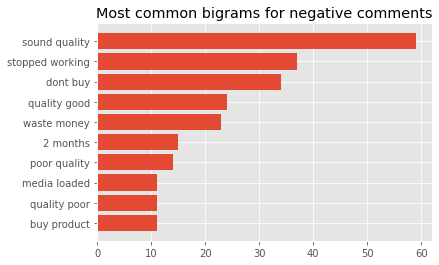

In [86]:
visualize_dict(negative_bi_grams_dict, 'Most common bigrams for negative comments', 0)

### ***Parts of Speech analysis*** ###

Focusing on adjectives

In [87]:
def return_pos(corpus: list, tag_name: str, n_most_common: int = 10) -> list:
    '''
    Return most common tokens that are a specific part of speech

    Args:
        corpus: corpus of tokens to look for
        tag_name: name of part of speech to look for (in universal tagset)
        n_most_common: how many most common tokens should be returned
    
    Returns:
        A dictionary of most common tokens of a specific part of speech as keys
        and their frequencies as values
    '''
    # tag all words in corpus
    tags = nltk.pos_tag(corpus, tagset = 'universal')

    # filter only those words that are of type tag_name
    tags = [word for word, tag in tags if tag == tag_name]

    # count the words and get only most common ones
    most_common = Counter(tags).most_common(n_most_common)
    
    return dict(zip([elem[0] for elem in most_common], [elem[1] for elem in most_common]))

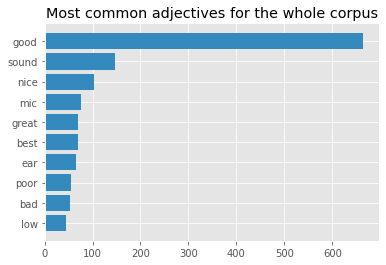

In [92]:
general_corpus_adjevtives = return_pos(corpus, 'ADJ')
visualize_dict(general_corpus_adjevtives, 'Most common adjectives for the whole corpus', 1)

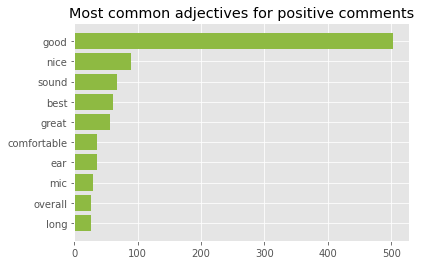

In [68]:
positive_comments_adjevtives = return_pos(positive_corpus, 'ADJ')
visualize_dict(positive_comments_adjevtives, 'Most common adjectives for positive comments', 5)

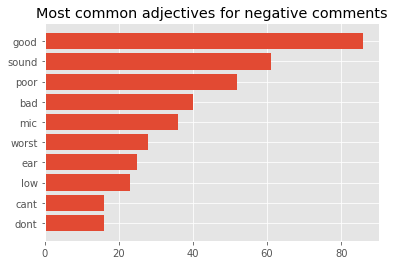

In [93]:
negative_comments_adjevtives = return_pos(negative_corpus, 'ADJ')
visualize_dict(negative_comments_adjevtives, 'Most common adjectives for negative comments', 0)

### ***Conclusions*** ###

The data consists of the customer name, review title, comment (actual review), color of the headphones, rating and the date when the review was posted.

There are 1604 review in total, 2 reviews don’t contain any textual information, 58 reviews have no comments, 10 review have no title and 2 reviews have both no comment and no title. 56 reviews with no comments and only titles (out of 58 mentioned) were probably misplaced and could be considered as having actual meaningful information in a form of a comment. 

There are 5 colors of headphones in the dataset: white, black, spirit lime, blur, iguana. Most of the reviews are associated with black or white types.
There are 1465 unique customers, with only 86 signed in as  default “Amazon Customer”.

Most of the comments aren't longer than 80 words (which is about 15% of single spaced A4 page). The median length of comments in 8 words. There are usually 1 or 2 sentences in a comment. The review titles are mostly short - usually 2 words. 

Most common words in all reviews are: “good”, “sound” and “quality”. Most common words in positive reviews are the same as the most common words in the whole dataset. This bias is probably due to the fact, that 58% of the whole dataset are positive comments, but only 32% are negative ones. Most common words in negative reviews are: “sound”, “quality” and “product”. Top single words for positive and negative reviews are in most cases the same and don’t provide any meaningful insight.

In terms of bigrams, customers generally say good things about the sound quality of the products, but in the terms of negative comments the sound quality isn't the only thing that is bothering them. They albo mention that the product stopped working after some time.